In [1]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline
%load_ext autoreload
%autoreload 

In [2]:
if not os.path.isdir('DampedNewtonPreconditioning_images'):
    os.makedirs('DampedNewtonPreconditioning_images')

In [3]:
"""To compute distance matrix"""
def distmat(x,y):
    
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum(a)

"""To Compute P"""
def GetP(u,K,v):
    return u*K*(v.T)

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter(x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2)

In [4]:
N=[400,500]

In [5]:
x=np.random.rand(2,N[0])-0.5
theta =2*np.pi*np.random.rand(1,N[1])
r=0.8+.2*np.random.rand(1,N[1])
y=np.vstack((r*np.cos(theta),r*np.sin(theta)))

In [6]:
import computational_OT

In [7]:
rho=0.95
c=0.05
DampedNewtonP=[]
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
epsilons=[0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
#epsilons=[0.3]
for eps in epsilons:
    # Line Search
    print("Damped Newton for epsilon="+str(eps)+":")    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize(np.ones(N[0]))
    a=a.reshape(a.shape[0],-1)
    b = normalize(np.ones(N[1]))
    b=b.reshape(b.shape[0],-1)

    #Kernel
    K=np.exp(-C/eps)
    f,g=a,b

    print("Doing for (",N[0],N[1],").")
    print( " |- Iterating")  
    start=time.time()
    Optimizer=computational_OT.DampedNewton(K,a,b,f,g,eps,rho,c)
    out=Optimizer._update(maxiter=50)
    results_DampedNewton.append(out)
    end=time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P")
    
    DampedNewtonP.append(GetP(np.exp(out[0]/eps),K,np.exp(out[1]/eps)))
    print( " |- Recording (unstabilized) Hessian \n")

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag*mat*diag
    Hessians_DampedNewton.append( mat )


Damped Newton for epsilon=0.1:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.2:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.3:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.4:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.5:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.75:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=1.0:
Doing for ( 400 500 ).
 |- Itera

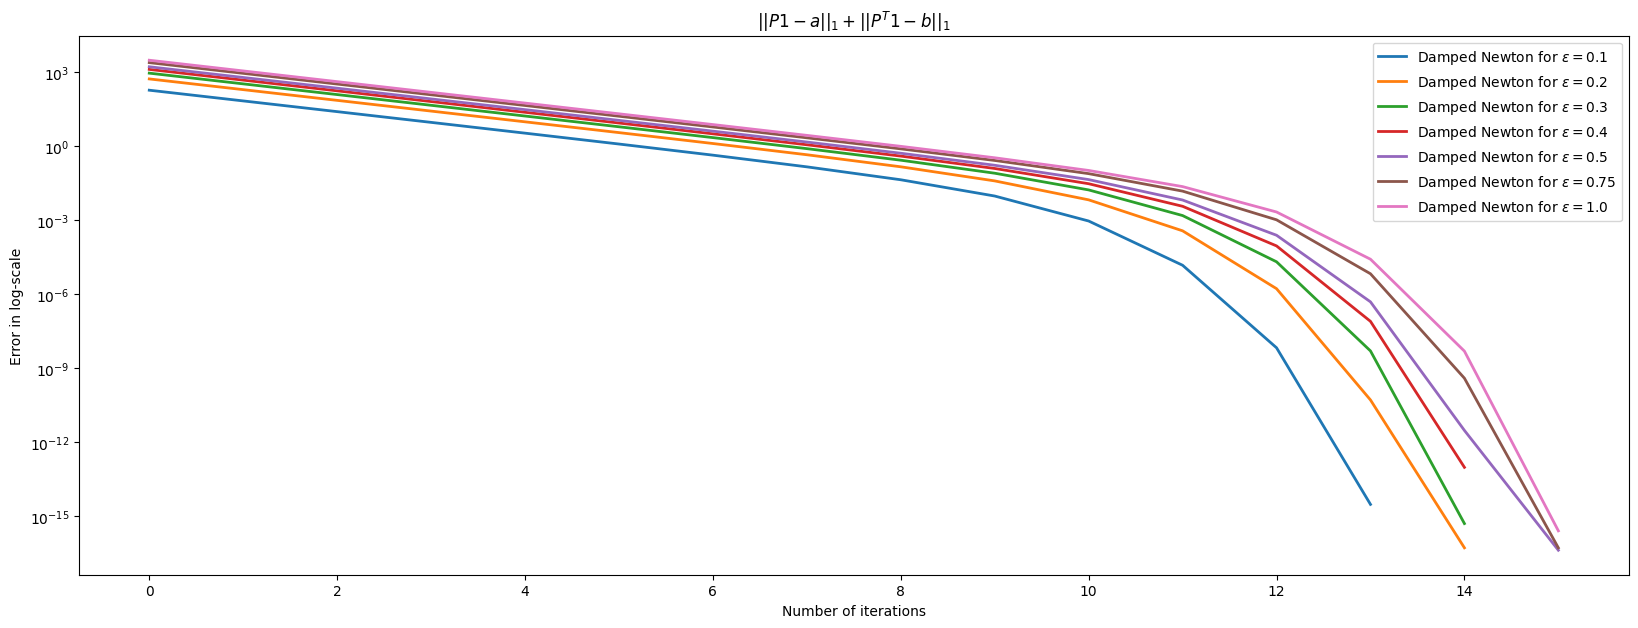


 Error plots can increase! The error is not the objective function!


In [8]:
plt.figure(figsize = (20,7))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T 1 -b||_1$")

for i in range(len(results_DampedNewton)):
  error=np.asarray(results_DampedNewton[i][2])+np.asarray(results_DampedNewton[i][3])
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_images/ErrorLinesearchNewton.png")
plt.show()

print("\n Error plots can increase! The error is not the objective function!")

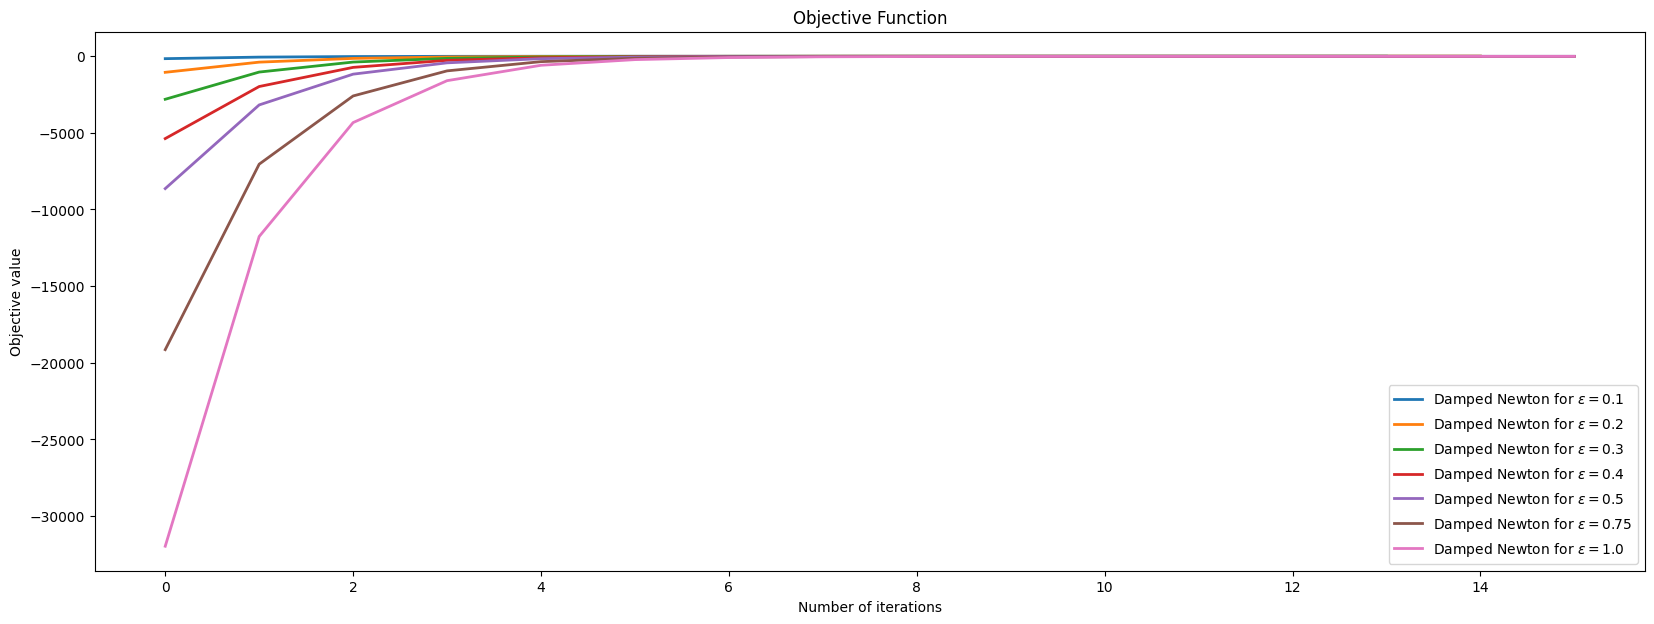

In [9]:
plt.figure(figsize = (20,7))
plt.title("$$")

plt.title("Objective Function")

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i][4]),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Objective value")
plt.legend()
plt.savefig("DampedNewtonPreconditioning_images/ObjectiveLineSearchNewton.png")
plt.show()


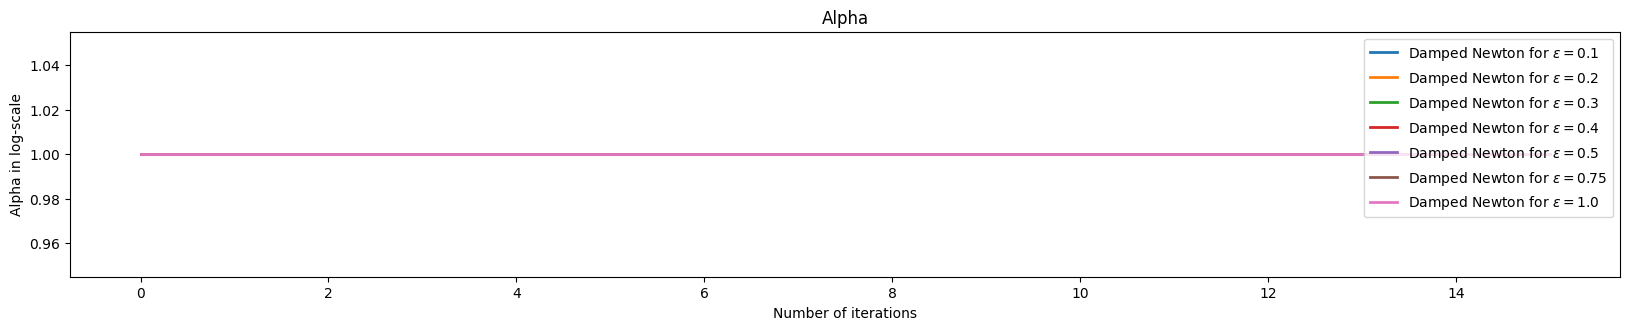

In [10]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i][5]),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_images/AlphaLineSearchNewton.png")
plt.show()



# I. Plotting spectrum as a function of $\varepsilon$

In [11]:
def spectral_decomposition(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])

    return eig,v

In [12]:
eigs=[]
eigvecs=[]
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    ev=spectral_decomposition( Hessians_DampedNewton[i] )
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [0.10557281 0.1864651  0.19578003 0.3375551  0.39952932 0.54661972
 0.56983882 0.68803217 0.7415433  0.8207762 ]
List of largest  eigenvalues:  [1.17922387 1.25845673 1.31196792 1.43016122 1.45338034 1.6004707
 1.66244498 1.80422001 1.81353496 1.89442723]

Spectral statistics of Hessian for epsilon=0.2
List of smallest eigenvalues:  [0.10557281 0.26880283 0.2835561  0.50474572 0.58806054 0.75795128
 0.76970571 0.87338556 0.9049565  0.93647344]
List of largest  eigenvalues:  [1.06352656 1.0950435  1.12661444 1.23029429 1.24204873 1.41193946
 1.49525428 1.7164439  1.73119717 1.89442719]

Spectral statistics of Hessian for epsilon=0.3
List of smallest eigenvalues:  [0.10557281 0.34791814 0.36636948 0.62845916 0.71116362 0.8625664
 0.86927634 0.93734173 0.95941188 0.9648442 ]
List of largest  eigenvalues:  [1.03515587 1.0405882  1.06265837 1.13072373 1.13743368 1.28883644
 1.37154093 1.63363058 1.65208194 1.89442

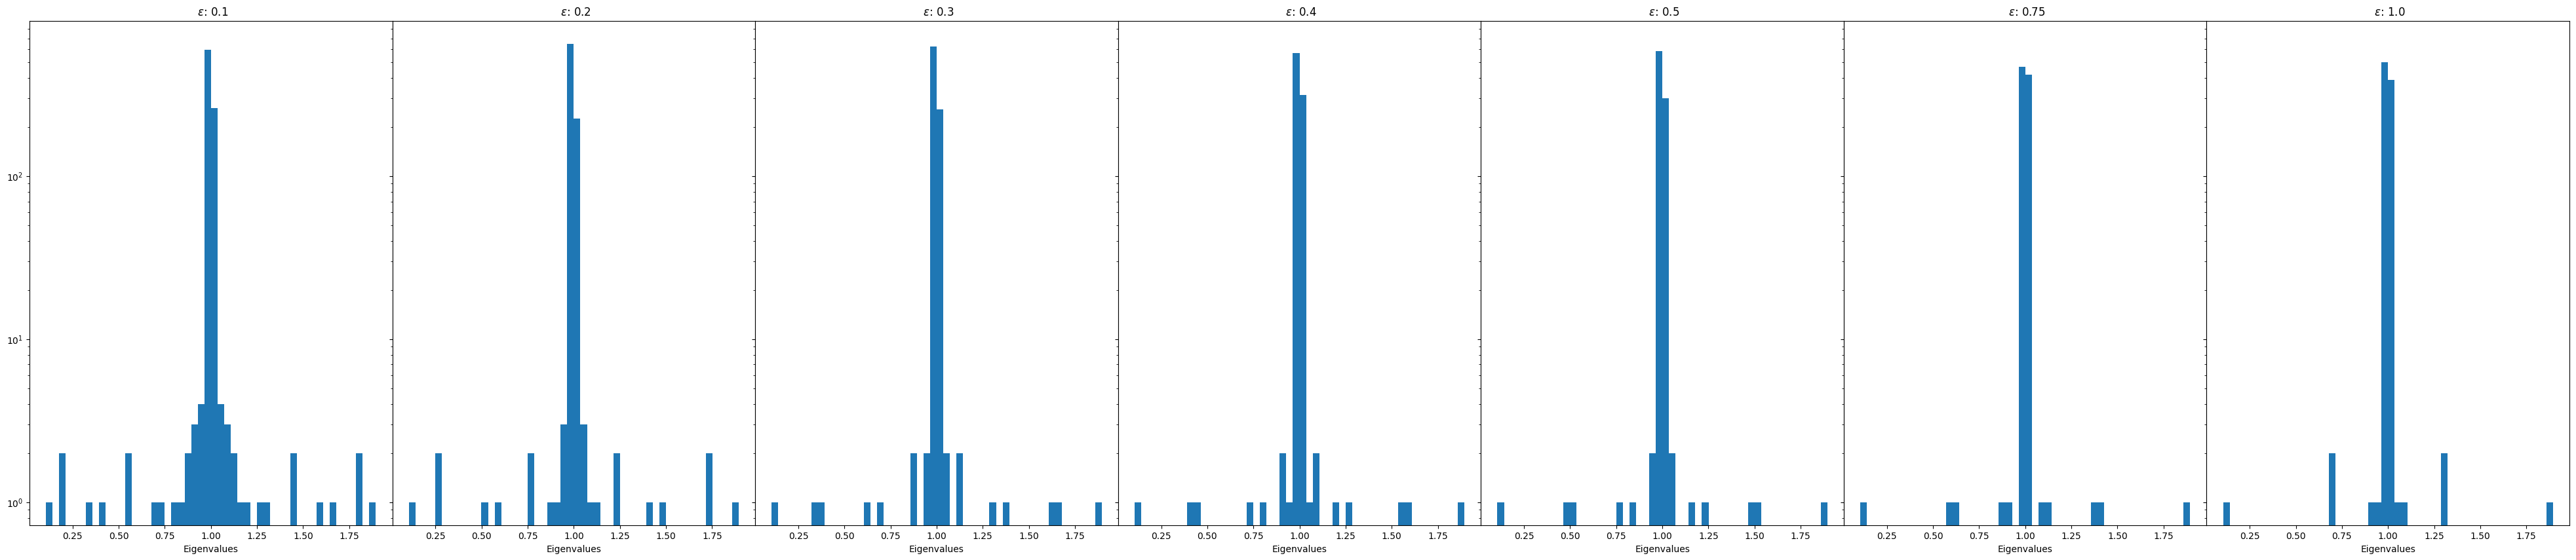

In [13]:
fig,ax=plt.subplots(figsize=(50,10),nrows=1, ncols=len(epsilons), sharey=True)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    ax[i].set_yscale( "log" )
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig("DampedNewtonPreconditioning_images/eigenhistunstabilized.png")
plt.show()

# II. Unstabilized vs stabilized Hessians

In [14]:
def build_preconditioners( modified_Hessian, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort(eigenvalues)
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        null_vector = null_vector/norm
    # Form other vectors (only 7)
    n,m = eigenvectors.shape
    precond_vectors = eigenvectors[:, [m-1,1,m-2,2,m-3,3,m-4] ]
    precond_vectors = []
    for index in [m-1,1,m-2,2,m-3,3,m-4]:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

In [15]:
def print_spectral_statistics_helper(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    #
    print( "List of smallest eigenvalues: ", eig[:5])
    print( "List of largest  eigenvalues: ", eig[-5:])
    min_index = np.argmin(eig)
    max_index = np.argmax(eig)
    min_value = eig[ min_index ]
    max_value = eig[max_index]
    min_vector = v[:, min_index]
    min_vector = min_vector/min_vector[0]
    max_vector = v[:,max_index]
    max_vector = max_vector/max_vector[0]
    condition_number = max_value/min_value
    print("Condition number: ", condition_number)
    return

def print_spectral_statistics_(mat, null_vector, precond_vectors):
    
    #
    print( "-- Without conditioning: " )
    print_spectral_statistics_helper(mat)
    
    #
    print( "-- Conditioning with null vector only: " )
    min_vector = null_vector
    min_vector = min_vector/np.linalg.norm(min_vector)
    min_vector = min_vector.reshape( (min_vector.shape[0], 1) )
    mat = mat + np.dot( min_vector, min_vector.T)
    print_spectral_statistics_helper(mat)

    #
    n,k = np.shape( precond_vectors )
    for i in range(k):
        vector = precond_vectors[:,i]
        value  = np.dot( np.dot( mat, vector ), vector)
        vector = vector.reshape( (vector.shape[0], 1) )
        P_matrix = np.identity(n) + (1/np.sqrt(value)-1)*np.dot( vector, vector.T)
        print( "-- Conditioning with ", i, " vectors")
        mat = np.dot( P_matrix, np.dot(mat, P_matrix) )
        print_spectral_statistics_helper(mat)
    # end for

    return

def print_spectral_statistics__(mat, null_vector, precond_vectors):
    
    #
    print( "-- Without conditioning: " )
    print_spectral_statistics_helper(mat)
    
    #
    print( "-- Conditioning with null vector only: " )
    min_vector = null_vector
    min_vector = min_vector/np.linalg.norm(min_vector)
    min_vector = min_vector.reshape( (min_vector.shape[0], 1) )
    mat = mat + np.dot( min_vector, min_vector.T)
    print_spectral_statistics_helper(mat)

    #
    n = len(null_vector)
    k = len( precond_vectors )
    for i in range(k):
        vector = precond_vectors[i]
        value  = np.dot( np.dot( mat, vector ), vector)
        vector = vector.reshape( (vector.shape[0], 1) )
        P_matrix = np.identity(n) + (1/np.sqrt(value)-1)*np.dot( vector, vector.T)
        print( "-- Conditioning with ", i+1, " vectors")
        mat = np.dot( P_matrix, np.dot(mat, P_matrix) )
        print_spectral_statistics_helper(mat)
    # end for

    return

In [16]:
# Using the largest epsilon's eigenvectors for conditioning
print( "Building preconditioning eigenvectors"  )
null_vector, precond_vectors = build_preconditioners( Hessians_DampedNewton[-1], ansatz=False )

for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = Hessians_DampedNewton[i]
    print_spectral_statistics__( Hessian, null_vector, precond_vectors)
    print("")


Building preconditioning eigenvectors
Spectral statistics of Hessian for epsilon=0.1
-- Without conditioning: 
List of smallest eigenvalues:  [0.10557281 0.1864651  0.19578003 0.3375551  0.39952932]
List of largest  eigenvalues:  [1.6004707  1.66244498 1.80422001 1.81353496 1.89442723]
Condition number:  17.944271909999344
-- Conditioning with null vector only: 
List of smallest eigenvalues:  [0.1864651  0.19578003 0.3375551  0.39952932 0.54661972]
List of largest  eigenvalues:  [1.6004707  1.66244498 1.80422001 1.81353496 1.89442723]
Condition number:  10.15968778140159
-- Conditioning with  1  vectors
List of smallest eigenvalues:  [0.1864651  0.19578003 0.3375551  0.39952932 0.54661972]
List of largest  eigenvalues:  [1.45338034 1.6004707  1.66244498 1.80422001 1.81353496]
Condition number:  9.725867869544256
-- Conditioning with  2  vectors
List of smallest eigenvalues:  [0.19516771 0.33748747 0.39823599 0.54693276 0.56696716]
List of largest  eigenvalues:  [1.586414   1.60663198 1

# III. Actual preconditioning

In [17]:
null_vector, precond_vectors = build_preconditioners( Hessians_DampedNewton[-1], ansatz=False )

In [24]:
rho=0.95
c=0.05
reset_starting_point=True
final_modified_Hessians = []
DampedNewtonP=[]
results_DampedNewton  = []
times_DampedNewton    = []

#epsilons=[0.05,0.08,0.1]
#precond_epsilons=[0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
precond_epsilons=[ 1.0, 0.75, 0.5, 0.4, 0.3, 0.1, 0.05]
#epsilons=[0.3]
f, g = None, None
for eps in precond_epsilons:
    # Line Search
    print("Damped Newton for epsilon="+str(eps)+":")    
    # Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize(np.ones(N[0]))
    a = a.reshape(a.shape[0],-1)
    b = normalize(np.ones(N[1]))
    b = b.reshape(b.shape[0],-1)

    #Kernel
    K=np.exp(-C/eps)

    if (f is None) or (g is None): 
        f,g=a,b

    print("Doing for (",N[0],N[1],").")
    print( " |- Iterating")  
    start=time.time()
    Optimizer=computational_OT.DampedNewton_With_Preconditioner(K,a,b,f,g,eps,rho,c,null_vector,precond_vectors[:])
    out=Optimizer._update(maxiter=50, iterative_inversion=30, timedebug=False,debug=False)
    results_DampedNewton.append(out)
    end=time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P")

    if not reset_starting_point:
        f = Optimizer.x[:a.shape[0]]
        g = Optimizer.x[a.shape[0]:]
        # f = f.reshape( f.shape[0], -1)
        # g = g.reshape( g.shape[0], -1)
    
    DampedNewtonP.append(GetP(np.exp(out[0]/eps),K,np.exp(out[1]/eps)))
    final_modified_Hessians.append( Optimizer.modified_Hessian )


Damped Newton for epsilon=1.0:
Doing for ( 400 500 ).
 |- Iterating
Time required for preconditioning matrix formation:  4.620826482772827

 Time taken to debug:  2.86102294921875e-06

 Time taken to evaluate p_k:  0.16870760917663574

 Time taken for unwinding:  0.023047208786010742

 Time taken for the complete code block:  4.816168785095215
Time required for preconditioning matrix formation:  4.4202656745910645

 Time taken to debug:  2.384185791015625e-06

 Time taken to evaluate p_k:  0.09239435195922852

 Time taken for unwinding:  0.024204730987548828

 Time taken for the complete code block:  4.539365768432617
Time required for preconditioning matrix formation:  4.472295761108398

 Time taken to debug:  2.1457672119140625e-06

 Time taken to evaluate p_k:  0.1412506103515625

 Time taken for unwinding:  0.025220394134521484

 Time taken for the complete code block:  4.641170501708984
Time required for preconditioning matrix formation:  4.353103876113892

 Time taken to debug:  

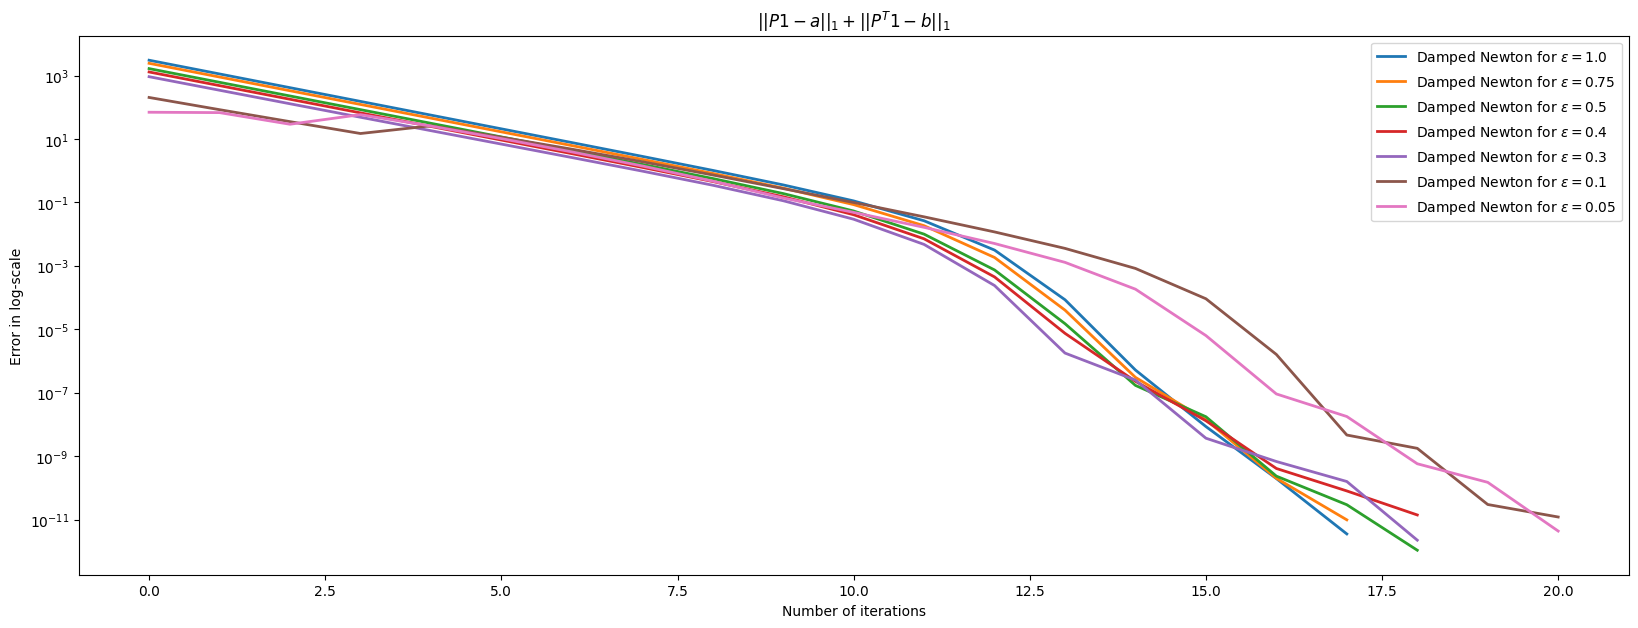


 Error plots can increase! The error is not the objective function!


In [22]:
plt.figure(figsize = (20,7))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T 1 -b||_1$")

for i in range(len(results_DampedNewton)):
  error=np.asarray(results_DampedNewton[i][2])+np.asarray(results_DampedNewton[i][3])
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_images/ErrorLinesearchNewton.png")
plt.show()

print("\n Error plots can increase! The error is not the objective function!")

ValueError: x and y can be no greater than 2D, but have shapes (18,) and (18, 1, 1)

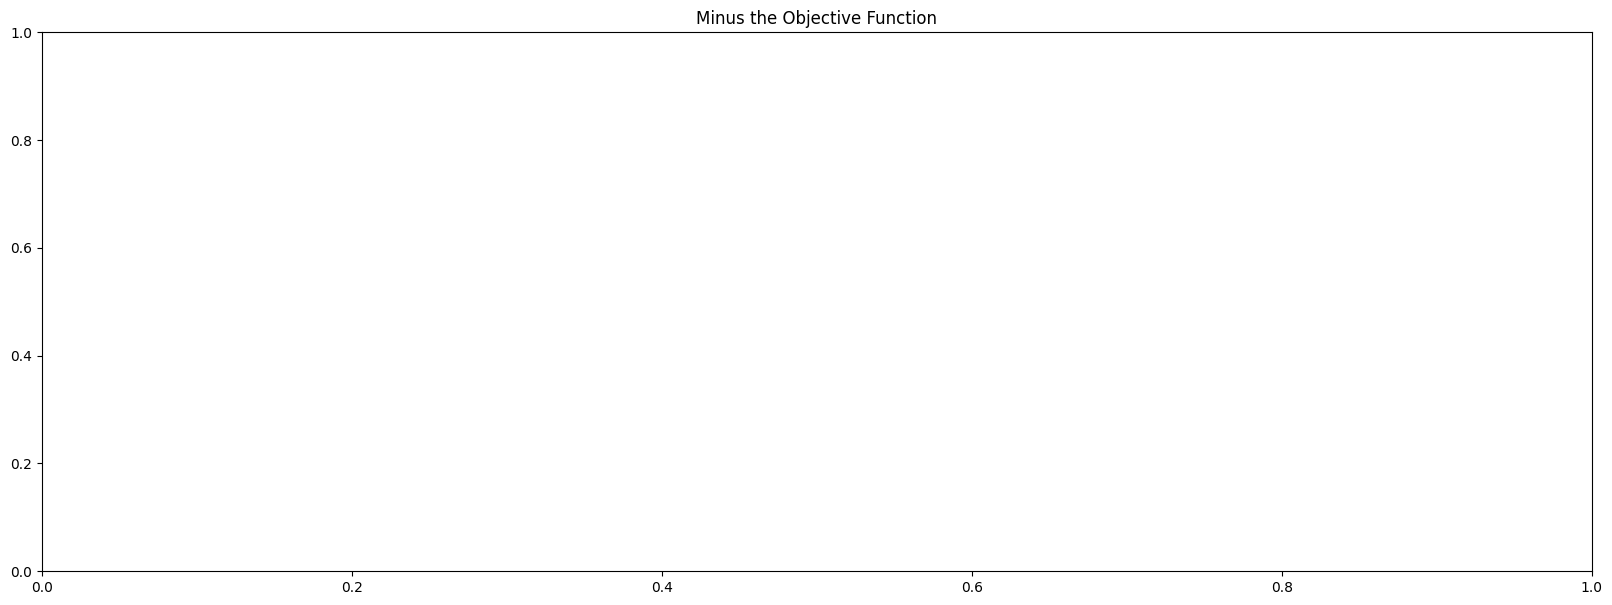

In [25]:
plt.figure(figsize = (20,7))
plt.title("$$")

plt.title("Minus the Objective Function")

for i in range(len(results_DampedNewton)):
  plt.plot( -np.asarray(results_DampedNewton[i][4]),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Objective value")
plt.yscale('log')
plt.legend()
plt.savefig("DampedNewtonPreconditioning_images/ObjectiveLineSearchNewton.png")
plt.show()

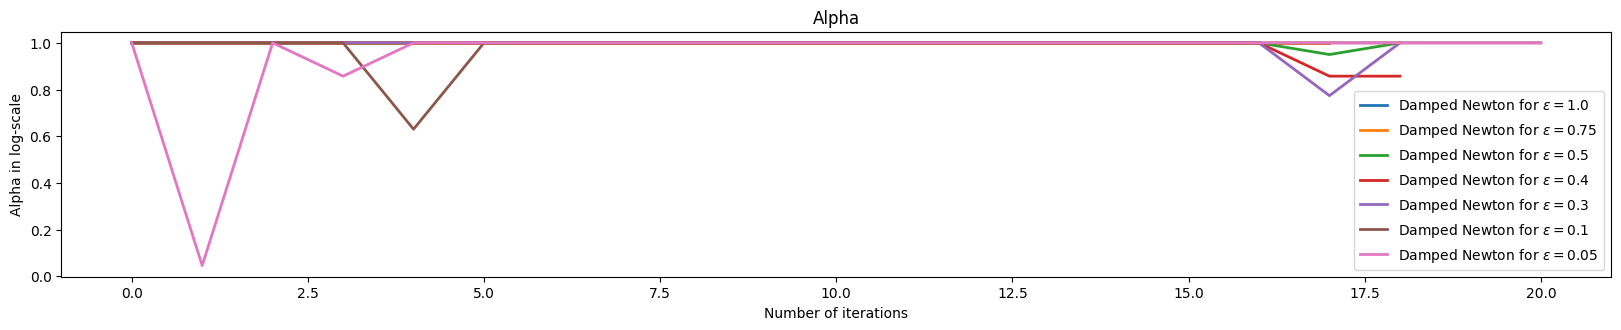

In [26]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i][5]),label='Damped Newton for $\epsilon=$'+ str(precond_epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonPreconditioning_images/AlphaLineSearchNewton.png")
plt.show()


# IV. More spectral statistics

In [27]:
# Using the largest epsilon's eigenvectors for conditioning
print( "Building preconditioning eigenvectors"  )
#null_vector, precond_vectors = build_preconditioners( Hessians_DampedNewton[-1], ansatz=False )
null_vector, precond_vectors = build_preconditioners( final_modified_Hessians[0], ansatz=False )

for i in range(len(precond_epsilons)):
    eps = precond_epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = final_modified_Hessians[i]
    print_spectral_statistics__( Hessian, null_vector, precond_vectors)
    print("")

Building preconditioning eigenvectors
Spectral statistics of Hessian for epsilon=1.0
-- Without conditioning: 
List of smallest eigenvalues:  [9.81853487e-16 6.48153459e-01 6.67346775e-01 9.15693706e-01
 9.44213642e-01]
List of largest  eigenvalues:  [1.05578636 1.08430629 1.33265323 1.35184654 2.        ]
Condition number:  2036963789057904.2
-- Conditioning with null vector only: 
List of smallest eigenvalues:  [0.64815346 0.66734677 0.91569371 0.94421364 0.98934581]
List of largest  eigenvalues:  [1.05578636 1.08430629 1.33265323 1.35184654 2.        ]
Condition number:  3.0856890029783988
-- Conditioning with  1  vectors
List of smallest eigenvalues:  [0.64815346 0.66734677 0.91569371 0.94421364 0.98934581]
List of largest  eigenvalues:  [1.01065419 1.05578636 1.08430629 1.33265323 1.35184654]
Condition number:  2.0856890029783988
-- Conditioning with  2  vectors
List of smallest eigenvalues:  [0.66734677 0.91569371 0.94421364 0.98934581 0.99001578]
List of largest  eigenvalues:  [

In [28]:
# Using the previous epsilon's eigenvectors for conditioning
print( "Building preconditioning eigenvectors"  )
null_vector, precond_vectors = build_preconditioners( Hessians_DampedNewton[-1], ansatz=False )

for i in range(len(precond_epsilons)):
    eps = precond_epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = final_modified_Hessians[i]
    print_spectral_statistics__( Hessian, null_vector, precond_vectors)
    print("")
    print("Building preconditioning eigenvectors")
    null_vector, precond_vectors = build_preconditioners( Hessian )
    print("")

Building preconditioning eigenvectors
Spectral statistics of Hessian for epsilon=1.0
-- Without conditioning: 
List of smallest eigenvalues:  [9.81853487e-16 6.48153459e-01 6.67346775e-01 9.15693706e-01
 9.44213642e-01]
List of largest  eigenvalues:  [1.05578636 1.08430629 1.33265323 1.35184654 2.        ]
Condition number:  2036963789057904.2
-- Conditioning with null vector only: 
List of smallest eigenvalues:  [0.64815346 0.66734677 0.91569371 0.94421364 0.98934581]
List of largest  eigenvalues:  [1.05578636 1.08430629 1.33265323 1.35184654 2.        ]
Condition number:  3.0856890029784
-- Conditioning with  1  vectors
List of smallest eigenvalues:  [0.64815346 0.66734677 0.91569371 0.94421364 0.98934581]
List of largest  eigenvalues:  [1.01065419 1.05578636 1.08430629 1.33265323 1.35184654]
Condition number:  2.0856890029783988
-- Conditioning with  2  vectors
List of smallest eigenvalues:  [0.66734677 0.91569371 0.94421364 0.98934581 0.99001578]
List of largest  eigenvalues:  [1.0